In [4]:
# 
is_on_colab = False

is_show_colab_env_info = False


if(is_on_colab):

    if(is_show_colab_env_info):

        
        def printm():

            process = psutil.Process(os.getpid())
            print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
            print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

        # memory footprint support libraries/code
        !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
        !pip install gputil
        !pip install psutil
        !pip install humanize  

        import psutil
        import humanize
        import os
        import GPUtil as GPU
        GPUs = GPU.getGPUs()
        # XXX: only one GPU on Colab and isn’t guaranteed
        gpu = GPUs[0]


        #GPU count and name
        !lscpu |grep 'Model name'
        !nvidia-smi -L
        printm()

  
    from google.colab import drive
    drive.mount('/content/drive')

    gdrive_home_dir = '/content/drive/My Drive/'

    project_dir = f'{gdrive_home_dir}DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'

    !ls '{ds_dir}'

else:
    project_dir = f'/disks/data/paper_projects/DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'


  

  

In [8]:
#12 Mar 2017
#In this file we are going to prepare data for CNN in different formats


from numpy import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import scipy.io as spio
import scipy
import os


from PIL import Image
from matplotlib import pyplot as plt 

#------------- Function Definition -------------
def FreqMat():
	ntype=['A', 'C', 'G', 'T']
	nuc=[]
	
	for n in ntype:
		nuc.append(n)
		
	for n in ntype:
		for m in ntype:
			nuc.append(n+m)
			
	for n in ntype:
		for m in ntype:
			for x in ntype:
				nuc.append(n+m+x)
				
	return nuc
	
#In this function we are going to convert each sequence into image-like representation in 
#which each sequence will be represented as a matrix where the rows is the sequence and the
#columns are tri-nucleotides 
#------------- one-hot vector with 1 channel in 2D rep for Tri-nucleotides -------------
def save_seq_as_img(data_filename, label_filename, save_dir, seqLength = 2000):
    
    with open(label_filename) as f:
        labels = [line.rstrip('\n') for line in f]
    #labels = list(filter(None, labels_Orig))  # This removes empty sequences.
    
    nuc=FreqMat()
    seqLength=2000  #edit this to 600 for other data    

    with open(data_filename) as f:
        k=-1 #index for the samples
        for line in f:
            k += 1
            a=np.zeros((seqLength-2,64))
            for i in range(seqLength-2):
                for j in range(20,len(nuc)):
                    if line[i:i+3]==nuc[j]:
                        a[i,j-20]=1
            
            img = Image.fromarray(a.astype(np.uint8))
            img.save(save_dir+f'/{labels[k]}/{k}.bmp', cmap=cm.gray)
            
            if(k%500==0):
                print('written image count:',k)
            #scipy.misc.imsave(save_dir+f'/{k}.bmp', a)                        
            #np.save(save_dir+f'/{k}.npy', a)
            #plt.imsave(save_dir+f'/{k}.png', a, cmap=cm.gray)                    
            
def get_unique_labels(label_filename):
    with open(label_filename) as f:
        labels = [line.rstrip('\n') for line in f]
        
    return list(set(labels))

In [9]:
inputseq_filename = f'{ds_dir}inputSeq_N_ReplacedBy_C.txt';
inputlabel_filename = f'{ds_dir}inputLabel.txt'

im_savedir = f'{ds_dir}imdata/'

# get the list of labels
unique_labels = get_unique_labels(inputlabel_filename)

# make directories (indicating labels) for the images 
import os
_ = [os.makedirs(im_savedir+''+label, exist_ok = True) for label in unique_labels]


# convert DNA sequences to bitmap images and save in the directory under label subdirectory
save_seq_as_img(data_filename = inputseq_filename, label_filename = inputlabel_filename, save_dir = im_savedir )



In [10]:
from numpy import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import scipy.io as spio
import scipy
import os


from PIL import Image
from matplotlib import pyplot as plt 

/disks/data/paper_projects/DeepCNC/data/imdata/


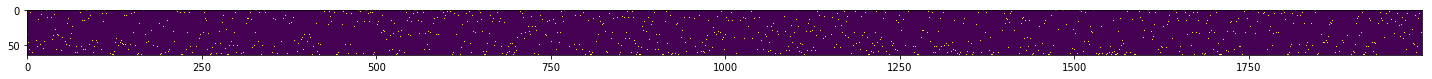

In [17]:
# test written images
plt.figure(figsize=(25,15))
im = plt.imread(im_savedir +'/0/0.bmp')
im.shape
plt.imshow(np.transpose(im))
print(im_savedir)

In [16]:
# verify one-hot encoding correctness
import glob

print("unique labels:", unique_labels)

for label in sorted(unique_labels):
    im_files = glob.glob(f'{im_savedir}/{label}/*.bmp')
    print("images in class",label,":", len(im_files))
    for im_file in im_files:
        img = plt.imread(im_file)
        if len(img)!=1998:
            print("sequence length incorrect:",im_file)
        if(np.any(np.sum(img,  axis = 1) !=1) ):
            print("onehot_encoding error:",im_file)
            print(not np.any(np.sum(img,  axis = 1) !=1) )
            break
            
#         for row in img:    
#             if sum(row)!=1:
#                 print(im_file)
#                 break

unique labels: ['1', '0']
images in class 0 : 18787
images in class 1 : 18487


In [24]:
# test written images
import random
indices_0 = list(range(18000))
indices_1 = list(range(18000, 37000))
random.shuffle(indices_0)
random.shuffle(indices_1)
zero_tests = []
one_tests = []

for i in indices_0[:1000]:
    im = plt.imread(f'/disks/data/paper_projects/DeepCNC/data/imdata/0/{i}.bmp')
    im.shape
    #plt.plot(np.sum(im,  axis = 1))
    #plt.imshow(im)
    zero_tests.append(np.any(np.sum(im,  axis = 1) !=1))
    
for i in indices_1[:1000]:
    im = plt.imread(f'/disks/data/paper_projects/DeepCNC/data/imdata/1/{i}.bmp')
    im.shape
    #plt.plot(np.sum(im,  axis = 1))
    #plt.imshow(im)
    one_tests.append(np.any(np.sum(im,  axis = 1) !=1))
    
print(np.any(zero_tests))
print(np.any(one_tests)

    

(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)
(1998, 64)

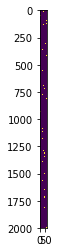

In [19]:
# import PIL
# img = PIL.Image.open('/disks/data/paper_projects/DeepCNC/data/imdata//0/1136.bmp')
# plt.imshow(img)

In [67]:
# def generate_kmers(alphabet, k):
  
#     def compute_kmers(letters, pos, k, kmer_lst, kmer_prefix):
#         if pos < k:
#             for l in letters:
#                 compute_kmers(letters, pos + 1, k, kmer_lst, kmer_prefix + l)
#         else:
#             for l in letters:
#                 kmer_lst.append(kmer_prefix+ l)

#     kmers = []

#     kmer_prefix = ""
#     kmer_start_pos = 1

#     compute_kmers(alphabet, kmer_start_pos , k, kmers, kmer_prefix)        

#     return kmers


# alphabet = ['A', 'C', 'G', 'T']
# k = 5
# kmers = generate_kmers(alphabet, k )
# print("Number of generated ",k,"-mers:",len(kmers))
# # print(kmers)

# kmer_to_idx = dict(zip(kmers, range(len(kmers))))

In [ ]:
# from sys import getsizeof


# integer_encoder = LabelEncoder()
# integer_encoder.fit(kmers)
# #print("classes: " ,list(integer_encoder.classes_))


# def seq_to_kmers(sequence, k, is_overlapping = True, stride = 1):
  
#   start_idx = 0
#   end_idx = len(sequence)
#   scan_end = start_idx + k

#   kmers = []
  
#   while(scan_end <= end_idx):
#     kmer = sequence[start_idx : scan_end]
#     kmers.append(kmer)
#     if(not is_overlapping):
#       start_idx += k      
#       scan_end +=k        
#     else:
#       start_idx += stride      
#       scan_end +=stride        

#   return kmers

# #print(seq_to_kmers("ACTGAT", 3, True))


# is_overlapping = True

# one_hot_encoder = OneHotEncoder(categories=[range(len(kmers))])
# input_features = []
# myBuffer = ''
# count =1;

# for sequence in sequences:
#   kmers_in_sequence = seq_to_kmers(sequence, 3, is_overlapping)
#   integer_encoded = integer_encoder.transform(kmers_in_sequence)
#   integer_encoded = np.array(integer_encoded).reshape(-1, 1)
#   one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
#   #input_features.append(one_hot_encoded.toarray())
#   # myBuffer += ("Seq no:" + str(count) + "  len: " + str(len(sequence))  + " array len: " + str( len(one_hot_encoded.toarray()))  + "\n" )
#   count = count + 1
#   if count%(len(sequences)//10) ==0:
#     print(count,"/",len(sequences),sep="")
#     print(getsizeof(input_features))  
  
# print( "Encoding of input DONE")   



  

    


In [ ]:
# print(len(kmers_in_sequence))
# print(one_hot_encoded.shape)
# print(one_hot_encoded[0])
# # print(integer_encoded[0:5])
# # print(kmers_in_sequence[0:5])
# # print(sequence[:10])
# # sorted_kmers = list(sorted(kmers))
# # print(sorted_kmers[32])

# # print()

# # integer_encoder_nucleotides = LabelEncoder()
# # integer_encoder_nucleotides.fit(alphabet)
# # lst = list(sequence)
# # integer_encoded_dna = integer_encoder_nucleotides.transform(lst)
# # print(integer_encoded_dna[:5])
# # print(lst[:5])
# # print(sorted(alphabet))

In [ ]:
# integer_encoder = LabelEncoder()
# integer_encoder.fit(alphabet)
# print("classes: " ,list(integer_encoder.classes_))


In [ ]:


# ####################  Encode Input Sequence ##############
# one_hot_encoder = OneHotEncoder(categories=[range(len(kmers))])
# input_features = []
# myBuffer = ''
# count =1;
# for sequence in sequences:
#     integer_encoded = integer_encoder.transform(list(sequence))
#     integer_encoded = np.array(integer_encoded).reshape(-1, 1)
#     one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
#     input_features.append(one_hot_encoded.toarray())
#     # myBuffer += ("Seq no:" + str(count) + "  len: " + str(len(sequence))  + " array len: " + str( len(one_hot_encoded.toarray()))  + "\n" )
#     count = count + 1

# print( "Encoding of input DONE")   
    
